In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import os
project_folder_path = '/content/drive/MyDrive/Kool/sissejuhatus_andmeteadusesse/projekt/Project_C4'
df_train = pd.read_csv(os.path.join(project_folder_path, "df_train.csv"))
df_test = pd.read_csv(os.path.join(project_folder_path, "df_test.csv"))

In [ ]:
season_map = {
    "Winter": 0,
    "Spring": 1,
    "Summer": 2,
    "Fall":   3
}

df_train['season'] = df_train['season'].map(season_map)
df_test['season']  = df_test['season'].map(season_map)

In [ ]:
!pip install catboost

In [ ]:
df_train.head()

,date,trips,median_duration,tavg,prcp,wspd,day_name,day_of_week,is_weekend,season
0,2013-06-01,8691,867,28.1,0.0,17.1,Saturday,5,1,1
1,2013-06-02,15942,813,27.8,0.0,21.1,Sunday,6,1,1
2,2013-06-03,7585,692,23.6,44.6,13.2,Monday,0,0,1
3,2013-06-04,15692,832,20.2,0.0,19.5,Tuesday,1,0,1
4,2013-06-05,15632,797,19.0,0.0,14.2,Wednesday,2,0,1


In [ ]:
df_test.head()

,date,trips,median_duration,tavg,prcp,wspd,day_name,day_of_week,is_weekend,season
0,2020-01-01,18160,542,4.4,0.0,17.9,Wednesday,2,0,0
1,2020-01-02,41614,551,3.7,0.9,12.6,Thursday,3,0,0
2,2020-01-03,31920,522,7.5,3.0,8.8,Friday,4,0,0
3,2020-01-04,29480,526,8.2,4.5,6.5,Saturday,5,1,0
4,2020-01-05,27636,500,5.7,0.3,7.4,Sunday,6,1,0


In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

split_date = "2023-01-01"

In [ ]:
import numpy as np

# Basic time components
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

# Fourier - weekly
df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Fourier - yearly
df['sin_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Trend
df['trend'] = np.arange(len(df))

# Weather interactions
df['temp_x_weekend'] = df['tavg'] * df['is_weekend']
df['rain_x_season'] = df['prcp'] * df['season']
df['wind_x_season'] = df['wspd'] * df['season']
df['temp_x_season'] = df['tavg'] * df['season']
df['month_x_temp'] = df['month'] * df['tavg']

# Weather polynomial
df['tavg2'] = df['tavg']**2
df['prcp2'] = df['prcp']**2
df['wspd2'] = df['wspd']**2

# Lags
df['lag_1'] = df['trips'].shift(1)
df['lag_7'] = df['trips'].shift(7)
df['lag_14'] = df['trips'].shift(14)
df['lag_30'] = df['trips'].shift(30)

# Rolling Means
df['rolling_7'] = df['trips'].rolling(7).mean()
df['rolling_14'] = df['trips'].rolling(14).mean()
df['rolling_30'] = df['trips'].rolling(30).mean()

# Rolling STD
df['rolling_std_7'] = df['trips'].rolling(7).std()
df['rolling_std_14'] = df['trips'].rolling(14).std()
df['rolling_std_30'] = df['trips'].rolling(30).std()

df = df.dropna().reset_index(drop=True)

df_train_new = df[df['date'] < split_date].reset_index(drop=True)
df_test_new  = df[df['date'] >= split_date].reset_index(drop=True)

df_train = df_train_new.copy()
df_test = df_test_new.copy()

features = [
    'median_duration',
    'tavg','tavg2',
    'prcp','prcp2',
    'wspd','wspd2',
    'day_of_week','is_weekend','season',
    'trend','sin_year','cos_year','sin_week','cos_week',
    'temp_x_weekend','rain_x_season','wind_x_season','temp_x_season','month_x_temp',
    'lag_1','lag_7','lag_14','lag_30',
    'rolling_7','rolling_14','rolling_30',
    'rolling_std_7','rolling_std_14','rolling_std_30'
]

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['trips']
y_test = df_test['trips']


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. CATEGORICAL FEATURES (CatBoost handles them natively)
cat_features = [
    'day_of_week',
    'is_weekend',
    'season',
]

# Convert categorical columns to int (CatBoost requirement)
for c in cat_features:
    df_train[c] = df_train[c].astype(int)
    df_test[c] = df_test[c].astype(int)

# 2. CATBOOST DATASET FORMAT (Pool)
train_pool = Pool(df_train[features], y_train, cat_features=cat_features)
test_pool = Pool(df_test[features], y_test, cat_features=cat_features)

# 3. TRAIN CATBOOST MODEL (TUNED FOR TIME SERIES)
model = CatBoostRegressor(
    iterations=2000,         # long training = stable
    learning_rate=0.03,      # good generalization
    depth=8,                 # captures non-linear seasonality
    l2_leaf_reg=5,
    loss_function='RMSE',
    random_state=42,
    verbose=200,
    task_type="CPU"          # set "GPU" if you have one
)

model.fit(train_pool)

# 4. PREDICT
cb_preds = model.predict(test_pool)

# 5. METRICS
MAE = mean_absolute_error(y_test, cb_preds)
RMSE = np.sqrt(mean_squared_error(y_test, cb_preds))
R2 = r2_score(y_test, cb_preds)

print("\n========== CATBOOST RESULTS ==========")
print(f"MAE:  {MAE:,.2f}")
print(f"RMSE: {RMSE:,.2f}")
print(f"R²:   {R2:.4f}")

0:	learn: 27821.6403734	total: 79.3ms	remaining: 2m 38s
200:	learn: 5902.7464552	total: 16.9s	remaining: 2m 31s
400:	learn: 4430.7172423	total: 24.4s	remaining: 1m 37s
600:	learn: 3677.4431565	total: 32s	remaining: 1m 14s
800:	learn: 3146.4282723	total: 40.2s	remaining: 1m
1000:	learn: 2713.3063682	total: 46s	remaining: 45.9s
1200:	learn: 2381.4419245	total: 53.6s	remaining: 35.7s
1400:	learn: 2113.0103607	total: 59.4s	remaining: 25.4s
1600:	learn: 1886.1272922	total: 1m 7s	remaining: 16.8s
1800:	learn: 1694.1715059	total: 1m 12s	remaining: 8.06s
1999:	learn: 1531.1942818	total: 1m 20s	remaining: 0us

========== CATBOOST RESULTS ==========
MAE:  15,170.40
RMSE: 17,720.91
R²:   0.6981


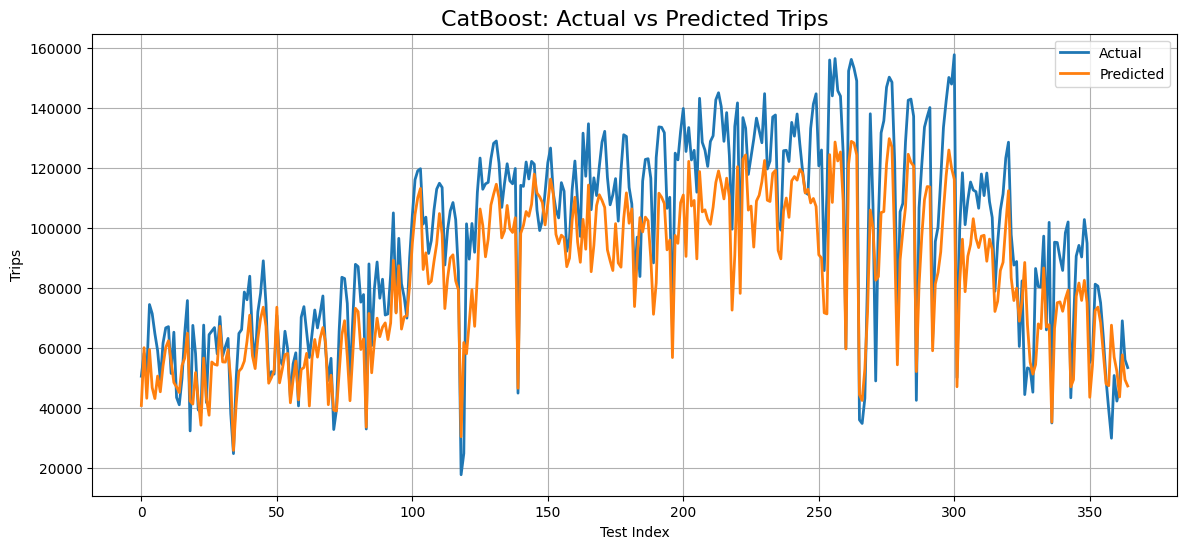

In [ ]:
# ACTUAL vs PREDICTED
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(cb_preds, label='Predicted', linewidth=2)
plt.title("CatBoost: Actual vs Predicted Trips", fontsize=16)
plt.xlabel("Test Index")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.show()

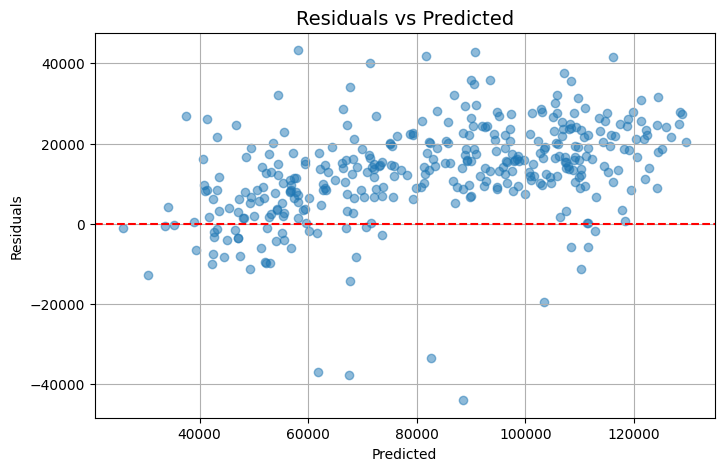

In [ ]:
residuals = y_test.values - cb_preds

# Residuals vs Predicted
plt.figure(figsize=(8,5))
plt.scatter(cb_preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

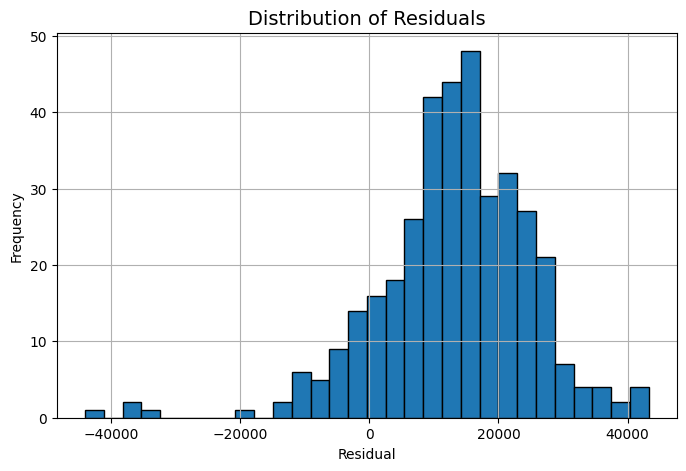

In [ ]:
# Residual Distribution
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals", fontsize=14)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# FEATURE IMPORTANCE
importances = model.get_feature_importance(train_pool)
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 25 Feature Importances:")
print(importance_df.head(25))


Top 25 Feature Importances:
            feature  importance
24        rolling_7   21.141842
25       rolling_14   10.897380
0   median_duration   10.554122
20            lag_1    8.556633
10            trend    5.447635
26       rolling_30    5.129982
3              prcp    4.114567
22           lag_14    3.307288
4             prcp2    2.918528
8        is_weekend    2.907833
27    rolling_std_7    2.671715
16    rain_x_season    2.621832
1              tavg    2.334624
21            lag_7    2.225772
12         cos_year    1.991828
13         sin_week    1.766009
28   rolling_std_14    1.373373
11         sin_year    1.195338
14         cos_week    1.182832
2             tavg2    1.081369
19     month_x_temp    1.070699
29   rolling_std_30    0.812364
7       day_of_week    0.771394
5              wspd    0.712289
15   temp_x_weekend    0.670896
